In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import keras_cv
import tqdm
from sklearn.manifold import TSNE
import time

In [2]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [3]:
if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

train_images = images[:10000]
test_images = images[10000:11000]

141545 images to train on


In [4]:
def preprocess(image):
    image = tf.data.Dataset.from_tensor_slices(image)
    image = image.map(lambda x: tf.reshape(x, [28, 28, 1]))
    image = image.map(lambda x: tf.cast(x, tf.float32))
    image = image.map(lambda x: x/255)
    image = image.shuffle(10000)
    image = image.batch(32)
    image = image.prefetch(20)
    return image

train_ds = preprocess(train_images)
test_ds = preprocess(test_images)

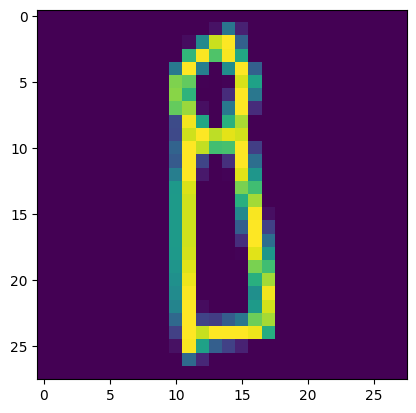

In [5]:
# Visualize the data
for img in train_ds.take(1):
    for i in img:
        i = np.reshape(i, (28,28))
        plt.imshow(i)
        break


In [24]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer_list =[
            tf.keras.layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1)
        ]

    def call(self, x, training=False):
        for layer in self.layer_list:
            x = layer(x)
        return x

In [25]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer_list = [
            tf.keras.layers.Dense(7*7*256, activation='relu', input_shape=(100,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Reshape((7,7,256)),
            tf.keras.layers.Conv2DTranspose(128, (5,5), strides=1, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(64, (5,5), strides=2, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(1, (5,5), strides=2, activation='tanh', padding='same'),
        ]

    def call(self, x, training=False):
        for layer in self.layer_list:
            x = layer(x)
        return x

In [10]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, d_optimizer, g_optimizer, loss_function):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_function = loss_function

    def train_step(self, images):
        noise = tf.random.normal([images.shape[0], 100])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            gen_loss = self.loss_function(tf.ones_like(fake_output), fake_output)
            disc_loss = self.loss_function(tf.ones_like(real_output), real_output) + self.loss_function(tf.zeros_like(fake_output), fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return {'train_gen_loss': gen_loss, 'train_disc_loss': disc_loss}
    
    def test_step(self, images):
        noise = tf.random.normal([images.shape[0], 100])
        generated_images = self.generator(noise, training=False)
        real_output = self.discriminator(images, training=False)
        fake_output = self.discriminator(generated_images, training=False)
        gen_loss = self.loss_function(tf.ones_like(fake_output), fake_output)
        disc_loss = self.loss_function(tf.ones_like(real_output), real_output) + self.loss_function(tf.zeros_like(fake_output), fake_output)
        return {'test_gen_loss': gen_loss, 'test_disc_loss': disc_loss}

In [11]:
def training_loop(model, train_ds, test_ds, epochs):
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        start = time.time()
        train_list = []
        test_list = []
        for image_batch in train_ds:
            result = model.train_step(image_batch)
            train_list.append(result)
        for test_batch in test_ds:
            result = model.test_step(test_batch)
            test_list.append(result)
        print(f'Generator train loss: {np.mean([i["train_gen_loss"] for i in train_list])} | Discriminator train loss: {np.mean([i["train_disc_loss"] for i in train_list])}')
        print(f'Generator test loss: {np.mean([i["test_gen_loss"] for i in test_list])} | Discriminator test loss: {np.mean([i["test_disc_loss"] for i in test_list])}')
        print(f'Epoch duration: {time.time()-start}')
        noise = tf.random.normal([5, 100])
        generated_images = model.generator(noise, training=False)
        for i in range(5):
            plt.subplot(1,5,i+1)
            plt.axis('off')
            plt.imshow(np.reshape(generated_images[i], (28,28)))
        plt.show()
        

Epoch 1/10
Generator train loss: 1.1949377059936523 | Discriminator train loss: 0.919022798538208
Generator test loss: 0.9174242615699768 | Discriminator test loss: 1.1352347135543823
Epoch duration: 27.26148223876953


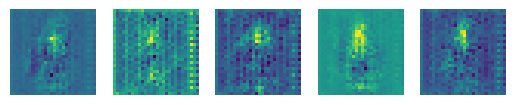

Epoch 2/10
Generator train loss: 0.8147621750831604 | Discriminator train loss: 1.202933430671692
Generator test loss: 0.8417259454727173 | Discriminator test loss: 1.1203498840332031
Epoch duration: 27.97695565223694


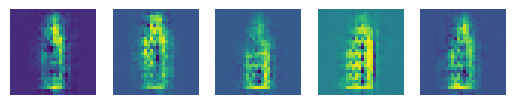

Epoch 3/10
Generator train loss: 0.8416668176651001 | Discriminator train loss: 1.1956418752670288
Generator test loss: 0.9180315732955933 | Discriminator test loss: 1.1059491634368896
Epoch duration: 28.197301626205444


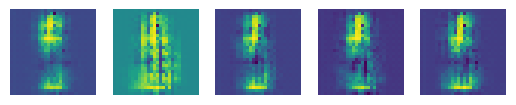

Epoch 4/10
Generator train loss: 0.928804337978363 | Discriminator train loss: 1.0702913999557495
Generator test loss: 1.0444667339324951 | Discriminator test loss: 0.9446926116943359
Epoch duration: 27.532116174697876


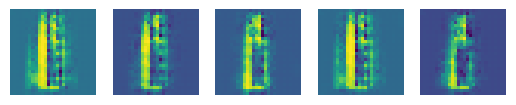

Epoch 5/10
Generator train loss: 0.9645608067512512 | Discriminator train loss: 1.029714584350586
Generator test loss: 1.2083311080932617 | Discriminator test loss: 0.8062102794647217
Epoch duration: 22.438526153564453


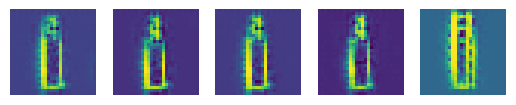

Epoch 6/10
Generator train loss: 1.0834733247756958 | Discriminator train loss: 0.9304317235946655
Generator test loss: 1.2106596231460571 | Discriminator test loss: 0.7776867151260376
Epoch duration: 22.221243619918823


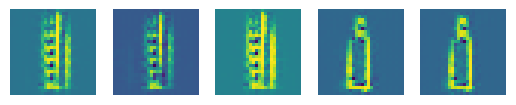

Epoch 7/10
Generator train loss: 1.2676618099212646 | Discriminator train loss: 0.7893701195716858
Generator test loss: 1.007411003112793 | Discriminator test loss: 0.7519220113754272
Epoch duration: 21.553557634353638


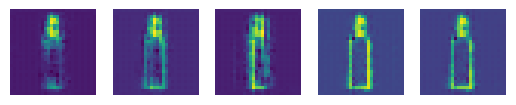

Epoch 8/10
Generator train loss: 1.3827693462371826 | Discriminator train loss: 0.7071505188941956
Generator test loss: 1.2214853763580322 | Discriminator test loss: 0.6265690326690674
Epoch duration: 20.746426343917847


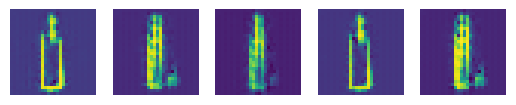

Epoch 9/10
Generator train loss: 1.6808007955551147 | Discriminator train loss: 0.5562089681625366
Generator test loss: 1.5503919124603271 | Discriminator test loss: 0.48753035068511963
Epoch duration: 21.101964235305786


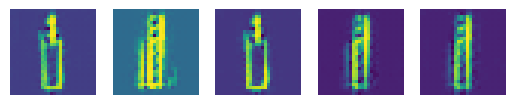

Epoch 10/10
Generator train loss: 1.9081709384918213 | Discriminator train loss: 0.5181584358215332
Generator test loss: 1.6750826835632324 | Discriminator test loss: 0.4092509150505066
Epoch duration: 21.062933921813965


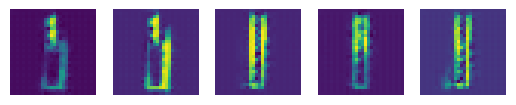

In [26]:
gan = GAN(Discriminator(),
         Generator(), 
         tf.keras.optimizers.Adam(1e-4), 
         tf.keras.optimizers.Adam(1e-4), 
         tf.keras.losses.BinaryCrossentropy(from_logits=True))

training_loop(gan, train_ds, test_ds, 10)
